In [183]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import umap
import numpy as np
from sklearn.preprocessing import minmax_scale
import hdbscan

In [184]:
import base64
from io import BytesIO
from PIL import Image

In [185]:
from tqdm.auto import tqdm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
import concept

In [187]:
path = '..\\data\\clean\\des_b64_wit_kag_0_of_48.tsv'
df = pd.read_table(path)

In [309]:
images = df['b64_bytes'].apply(lambda x: BytesIO(base64.b64decode(x)))

image_list = images.to_list()

In [190]:
texts = df['context_page_description'].to_list()


In [191]:
interleaved_lists = list(itertools.chain(*zip(texts, image_list)))

# Embeddings

In [192]:
embedding_model = SentenceTransformer("clip-ViT-B-32")

c:\Users\Martin\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning:

Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.



In [193]:
batch_size = 128
n = len(image_list)

image_embeds = []
for i in tqdm(range(0, n, batch_size)):
    i_end = min(i+batch_size, n)
    batch = image_list[i:i_end]
    images = [Image.open(img) for img in batch]
    batch_embed = embedding_model.encode(images)
    image_embeds.extend(batch_embed.tolist())

text_embeds = []
for i in tqdm(range(0, n, batch_size)):
    i_end = min(i+batch_size, n)
    batch = texts[i:i_end]
    batch_embed = embedding_model.encode(batch)
    text_embeds.extend(batch_embed.tolist())

100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


In [194]:
interleaved_embeddings = list(itertools.chain(*zip(text_embeds, image_embeds)))

In [195]:
normalized_embeddings = minmax_scale(interleaved_embeddings, feature_range=(-1, 1))

In [196]:
added_embeddings = [a+b for a,b in zip(text_embeds, image_embeds)]

In [197]:
normalized_img_embeddings = minmax_scale(image_embeds, feature_range=(-1, 1))
normalized_text_embeddings = minmax_scale(text_embeds, feature_range=(-1, 1))
added_normalized_embeddings = [a+b for a,b in zip(normalized_img_embeddings, normalized_text_embeddings)]

In [198]:
umap_model = umap.UMAP(n_neighbors=5,
                        n_components=5,
                        min_dist=0.1,
                        metric='cosine') # Important that metric is cosine to match clip
# parameters from base concept model

In [401]:
umap_embedding = umap_model.fit_transform(added_embeddings)

In [402]:
hue = []
flipper = True
for i in range(len(umap_embedding)):
    if flipper:
        hue.append('red')
    else:
        hue.append('blue')
    flipper = not flipper

<AxesSubplot:>

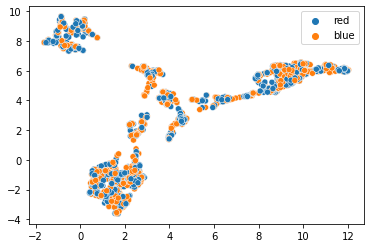

In [403]:

sns.scatterplot(x=umap_embedding[:,0], y=umap_embedding[:,1], hue=hue)

<AxesSubplot:>

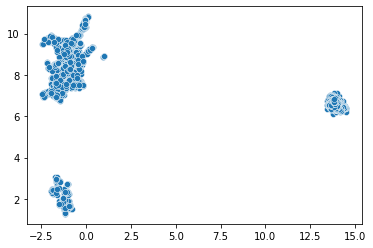

In [404]:
umap_model2 = umap.UMAP(n_neighbors=5,
                        n_components=5,
                        min_dist=0.1,
                        metric='cosine')

umap_embedding2 = umap_model.fit_transform(text_embeds)
sns.scatterplot(x=umap_embedding2[:,0], y=umap_embedding2[:,1])

# Clustering

In [405]:
umap_embed = umap_embedding

In [406]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40)
clusterer.fit(umap_embed)




HDBSCAN(min_cluster_size=40)

<AxesSubplot:ylabel='$\\lambda$ value'>

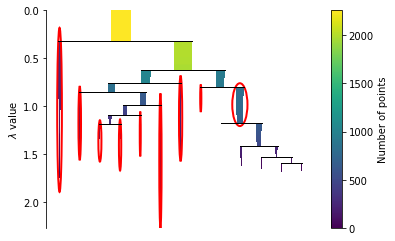

In [407]:
clusterer.condensed_tree_.plot(select_clusters=True)

In [408]:
import plotly.express as px
palette = ['#1c17ff', '#faff00', '#8cf1ff', '#738FAB', '#030080', '#738fab']

u = umap_embed
colors = [str(x) for x in clusterer.labels_]

fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    color=colors,
    color_discrete_sequence=palette
)
fig.update_traces(

)

# C-tf-idf

In [409]:
classes = {}
for label in set(clusterer.labels_):
    classes[label] = {
        'vocab': set(),
        'tokens': [],
        'tfidf_array': None
    }
classes

{0: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 1: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 2: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 3: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 4: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 5: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 6: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 7: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 8: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 -1: {'vocab': set(), 'tokens': [], 'tfidf_array': None}}

In [410]:
docs = df['context_page_description'].to_frame()
docs['class'] = clusterer.labels_

In [411]:
import re
import nltk
# first lowercase and remove punctuation
alpha = re.compile(r'[^a-zA-Z ]+')
docs['context_page_description'] = docs['context_page_description'].apply(lambda x: 
    alpha.sub('', x.lower())
)
docs['tokens']=docs['context_page_description'].apply(lambda x: 
    nltk.tokenize.wordpunct_tokenize(x)
)

In [412]:
docs

,context_page_description,class,tokens
0,scolopendra gigantea also known as the peruvia...,1,"[scolopendra, gigantea, also, known, as, the, ..."
1,teucrium corymbosum commonly known as forest g...,1,"[teucrium, corymbosum, commonly, known, as, fo..."
2,the christianpatterson rental property is a tw...,3,"[the, christianpatterson, rental, property, is..."
3,mal thle is a village and municipality in brun...,3,"[mal, thle, is, a, village, and, municipality,..."
4,hymenocallis occidentalis is a plant species n...,1,"[hymenocallis, occidentalis, is, a, plant, spe..."
...,...,...,...
2254,george rawlinson was a british scholar histori...,8,"[george, rawlinson, was, a, british, scholar, ..."
2255,sparta precinct is located in randolph county ...,3,"[sparta, precinct, is, located, in, randolph, ..."
2256,auburn lake trails is a censusdesignated place...,0,"[auburn, lake, trails, is, a, censusdesignated..."
2257,hannah yelland is a britishborn actress now li...,7,"[hannah, yelland, is, a, britishborn, actress,..."


In [413]:
docs.apply(lambda row:
    classes[row['class']]['tokens'].extend(row['tokens']), axis=1
)


0       None
1       None
2       None
3       None
4       None
        ... 
2254    None
2255    None
2256    None
2257    None
2258    None
Length: 2259, dtype: object

In [414]:
nltk.download('stopwords')
for c in classes.keys():
    stopwords = set(nltk.corpus.stopwords.words('english'))
    # stopwords from nltk are all lowercase (so are our tokens)
    classes[c]['tokens'] = [
        word for word in classes[c]['tokens'] if word not in stopwords
    ]
    print(f"{c}: {len(classes[c]['tokens'])}")

0: 6423
1: 4258
2: 2028
3: 21959
4: 4067
5: 2799
6: 1192
7: 4771
8: 3308
-1: 7273


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [415]:
vocab = set()
for c in classes.keys():
    vocab = vocab.union(set(classes[c]['tokens']))
    classes[c]['vocab'] = set(classes[c]['tokens'])


In [416]:
tf = np.zeros((len(classes.keys()), len(vocab)))

for c, _class in enumerate(classes.keys()):
    for t, term in enumerate(tqdm(vocab)):
        tf[c, t] = classes[_class]['tokens'].count(term)

100%|██████████| 16220/16220 [00:01<00:00, 9484.72it/s]


In [417]:
idf = np.zeros((1, len(vocab)))

# calculate average number of words per class
A = tf.sum() / tf.shape[0]

for t, term in enumerate(tqdm(vocab)):
    # frequency of term t across all classes
    f_t = tf[:,t].sum()
    # calculate IDF
    idf_score = np.log(1 + (A / f_t))
    idf[0, t] = idf_score

100%|██████████| 16220/16220 [00:00<00:00, 219197.31it/s]


In [418]:
tf_idf = tf*idf

In [419]:
n = 5
top_idx = np.argpartition(tf_idf, -n)[:, -n:]
vlist = list(vocab)

for c, _class in enumerate(classes.keys()):
    topn_idx = top_idx[c, :]
    topn_terms = [vlist[idx] for idx in topn_idx]
    print(_class,topn_terms)

0 ['states', 'united', 'county', 'population', 'census']
1 ['native', 'found', 'genus', 'family', 'species']
2 ['uss', 'ship', 'navy', 'built', 'war']
3 ['district', 'county', 'city', 'station', 'located']
4 ['force', 'asteroid', 'order', 'municipality', 'army']
5 ['team', 'player', 'basketball', 'played', 'professional']
6 ['la', 'saint', 'countess', 'marriage', 'saturday']
7 ['music', 'singer', 'known', 'american', 'band']
8 ['served', 'film', 'th', 'american', 'war']
-1 ['professional', 'american', 'baseball', 'first', 'played']


# Images

In [420]:
# based on concept: https://github.com/MaartenGr/Concept/tree/c0ab7b0bad4a2fb4003c33d0031f75ab342ef7b9


In [421]:
def _extract_exemplars(clusterer):
    image_nr = [i for i in range(len(clusterer.labels_))]

    # prep condensed tree
    condensed_tree = clusterer.condensed_tree_
    raw_tree = condensed_tree._raw_tree
    clusters = sorted(condensed_tree._select_clusters())
    cluster_tree = raw_tree[raw_tree['child_size']>1]

    # find points with maximum lambda in each leaf
    representative_images = {}
    cluster_labels = sorted(list(set(clusterer.labels_)))
    for cluster in cluster_labels:
        if cluster != -1:
            leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, clusters[cluster])
            exemplars = np.array([])

            for leaf in leaves:
                max_lambda = raw_tree['lambda_val'][raw_tree['parent']==leaf].max()
                points = raw_tree['child'][(raw_tree['parent'] == leaf) &
                                            (raw_tree['lambda_val'] == max_lambda)]
                exemplars = np.hstack((exemplars, points))

            representative_images[cluster] = {"Indices": [int(index) for index in exemplars],
                                                "Names": [image_nr[int(index)] for index in exemplars]}

    return representative_images

representative_images = _extract_exemplars(clusterer)



In [422]:
np.array(image_embeds)

array([[ 0.27612305, -0.33129883, -0.16552734, ...,  0.62792969,
        -0.09448242,  0.33374023],
       [-0.31884766,  0.12561035, -0.51025391, ...,  0.30786133,
         0.01325226, -0.24267578],
       [ 0.05953979,  0.22363281, -0.32324219, ...,  0.93554688,
        -0.27124023, -0.07385254],
       ...,
       [ 0.11120605, -0.27197266,  0.19226074, ...,  0.78808594,
         0.07037354, -0.19946289],
       [ 0.45776367, -0.07611084, -0.41967773, ...,  0.08093262,
         0.32788086,  0.10107422],
       [ 0.37841797, -0.19714355, -0.09649658, ...,  0.44287109,
        -0.03967285,  0.05480957]])

In [423]:
def _extract_cluster_embeddings(image_embeddings,
                                    representative_images,
                                    clusterer):
        """ Create a concept cluster embedding for each concept cluster by
        averaging the exemplar embeddings for each concept cluster.
        Arguments:
            image_embeddings: All image embeddings
            representative_images: The representative images per concept cluster
        Updates:
            cluster_embeddings: The embeddings for each concept cluster
        Returns:
            exemplar_embeddings: The embeddings for each exemplar image
        """
        image_embeddings = np.array(image_embeddings)
        exemplar_embeddings = {}
        cluster_embeddings = []
        cluster_labels = sorted(list(set(clusterer.labels_)))
        for label in cluster_labels[1:]:
            embeddings = image_embeddings[np.array([index for index in
                                                    representative_images[label]["Indices"]])]
            cluster_embedding = np.mean(embeddings, axis=0).reshape(1, -1)

            exemplar_embeddings[label] = embeddings
            cluster_embeddings.append(cluster_embedding)

        cluster_embeddings = cluster_embeddings

        return exemplar_embeddings, cluster_embeddings
exemplar_embeddings, cluster_embeddings = _extract_cluster_embeddings(image_embeds,
                                                        representative_images, clusterer)

In [424]:
def _extract_exemplar_subset(exemplar_embeddings,
                            representative_images,
                            cluster_embeddings,
                            clusterer, diversity=0.3):
        """ Use MMR to filter out images in the exemplar set
        Arguments:
            exemplar_embeddings: The embeddings for each exemplar image
            representative_images: The representative images per concept cluster
        Returns:
            selected_exemplars: A selection (8) of exemplar images for each concept cluster
        """
        cluster_labels = sorted(list(set(clusterer.labels_)))
        selected_exemplars = {cluster: concept._mmr.mmr(cluster_embeddings[cluster],
                                           exemplar_embeddings[cluster],
                                           representative_images[cluster]["Indices"],
                                           diversity=diversity,
                                           top_n=9)
                              for index, cluster in enumerate(cluster_labels[1:])}

        return selected_exemplars

selected_exemplars = _extract_exemplar_subset(exemplar_embeddings,
                                                    representative_images,
                                                    cluster_embeddings, clusterer)

In [425]:
selected_exemplars

{0: [260, 323, 302, 638, 1613, 1555, 937, 762, 673],
 1: [347, 897, 487, 1465, 24, 1807, 330, 1292, 399],
 2: [1894, 938, 1074, 332, 2135, 653, 671, 157, 1511],
 3: [1823, 1186, 2063, 881, 1377, 576, 138, 136, 1838],
 4: [1652, 1900, 341, 1142, 1119, 1489, 1686, 1620, 2045],
 5: [523, 957, 339, 1112, 1315, 706, 1713, 1418, 376],
 6: [534, 1269, 1005, 78, 1427, 2044, 888, 2070, 1029],
 7: [1475, 893, 1099, 1157, 858, 18, 529, 1336, 1730],
 8: [1865, 1751, 2124, 34, 1962, 1472, 75, 359, 188]}

In [426]:
def _cluster_representation(images,
                            selected_exemplars,
                            clusterer):
        """ Cluster exemplars into a single image per concept cluster
        Arguments:
            images: A list of paths to each image
            selected_exemplars: A selection of exemplar images for each concept cluster
        """
        # Find indices of exemplars per cluster
        cluster_labels = sorted(list(set(clusterer.labels_)))
        sliced_exemplars = {cluster: [[j for j in selected_exemplars[cluster][i:i + 3]]
                                      for i in range(0, len(selected_exemplars[cluster]), 3)]
                            for cluster in cluster_labels[1:]}
        
        # combine exemplars into a single image
        cluster_images = {}
        for cluster in cluster_labels[1:]:
            images_to_cluster = [[Image.open(images[index]) for index in sub_indices] for sub_indices in sliced_exemplars[cluster]]
            cluster_image = concept._visualization.get_concat_tile_resize(images_to_cluster)
            cluster_images[cluster] = cluster_image

            # Make sure to properly close images
            '''
            for image_list in images_to_cluster:
                for image in image_list:
                    image.close()
            '''

        return cluster_images
cluster_images = _cluster_representation(image_list, selected_exemplars, clusterer)

In [427]:
cluster_images

{0: <PIL.Image.Image image mode=RGB size=200x200 at 0x1EA2407D940>,
 1: <PIL.Image.Image image mode=RGB size=200x200 at 0x1EA0DD82340>,
 2: <PIL.Image.Image image mode=RGB size=200x200 at 0x1EA0F975820>,
 3: <PIL.Image.Image image mode=RGB size=200x200 at 0x1EA12B2EC70>,
 4: <PIL.Image.Image image mode=RGB size=200x200 at 0x1E9E376CC40>,
 5: <PIL.Image.Image image mode=RGB size=200x200 at 0x1EA104CED90>,
 6: <PIL.Image.Image image mode=RGB size=200x200 at 0x1EA1205A640>,
 7: <PIL.Image.Image image mode=RGB size=200x200 at 0x1EA0F99E700>,
 8: <PIL.Image.Image image mode=RGB size=200x200 at 0x1EA1304C3A0>}

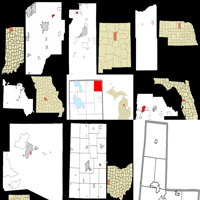

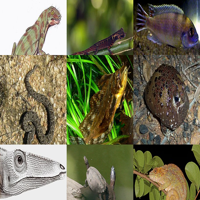

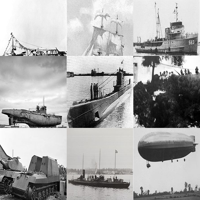

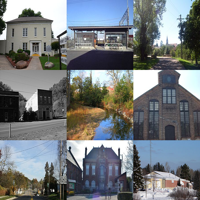

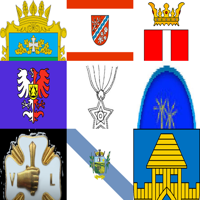

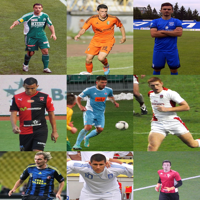

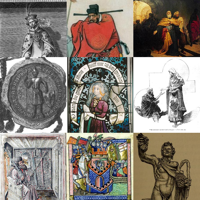

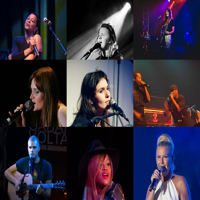

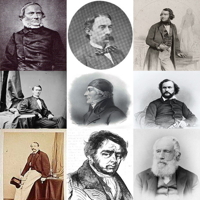

In [428]:
display(*cluster_images.values())